# Система определения возраста по фотографии

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. Метрика *MAE* полученной системы должна быть меньше 8 лет.

Разделим работу на следующие части:
### [**Часть 1.** Изучение и подготовка датасета](#step_1)
### [**Часть 2.** Обучение модели](#step_2)
### [**Часть 3.** Анализ обученной модели](#step_3)

## 1. Исследовательский анализ данных <a id='step_1'></a> 

Для начала импортируем в проект все библиотеки, используемые в проекте.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

Теперь откроем файл с данными и датасетом и посмотрим на их размер.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
print(labels.info())

Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


В датасете 7591 изображение с отметками о возрасте. Файл *labels.csv* содержит столбцы с именами файлов и возрастом изображенных на ниъ людей. Изучим распределение возрастов в наших данных.

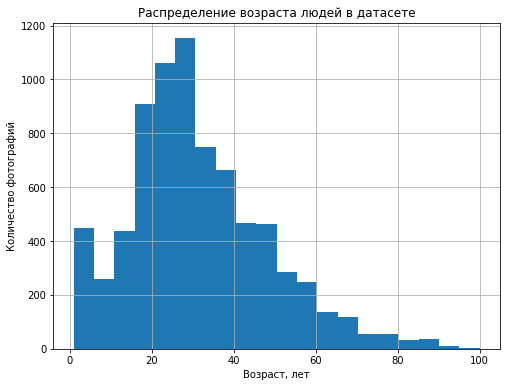

In [3]:
fig = plt.figure(figsize=(8,6))
labels['real_age'].hist(bins=20)
plt.title('Распределение возраста людей в датасете')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество фотографий')
plt.show()

Основная масса изображений - люди возрастом от 10 до 50 лет. Скорее всего возраст людей в этих пределах модель будет определять более точно, особенно людей 15-35 лет. Скорее всего людей от 50 и старше модель будет определять с большей погрешностью.

Теперь посмотрим случайные 16 фотографий из данного нам датасета, чтобы понять особенности данных.

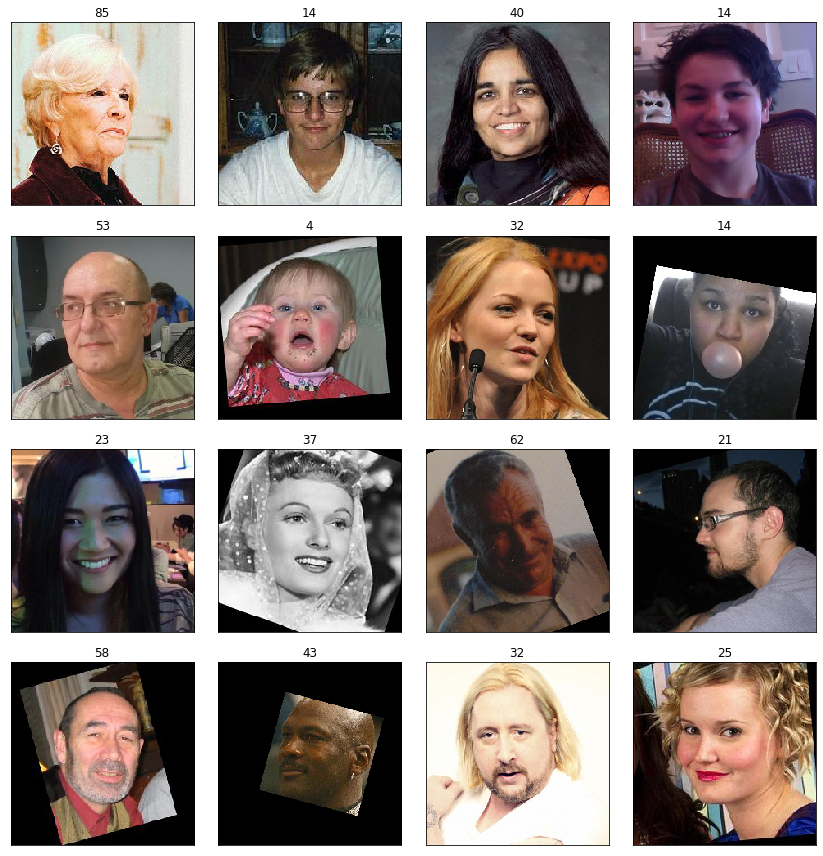

In [4]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i+3])
    plt.title(target[i+3])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На фотографиях мы можем видеть что обучение модели может усложняться или давать недостоверную информацию из-за предметов частично или полностью закрывающих лицо, а также ракурса, например, фото в профиль дают меньше информации.

## 2. Обучение модели <a id='step_2'></a> 

Поскольку код этого раздела запускался в отдельном GPU-тренажере, здесь мы его приведем как текст, а также укажем результаты вывода, полученного с помощью этого кода.

Для аугментации данных отразим некоторые изображения горизонтально и добавим угол поворота 20 градусов. Выделим 25% изображений в качестве тестовых. Наша модель будет работать с использованием архитектуры ResNet с 50 слоями. Результаты этой обработки передадим в полносвязный слой с 64 нейронами и функцией активации *ReLU*, а затем в финальный полносвязный слой с 1 нейроном и той же *ReLU*-функцией. В качестве оптимизатора будет использовать *Adam* с обучающий рейтингом 0.0001, функцию потерь будем использовать **MAE**, и метрику тоже **MAE**. Обучение модели проведем в 7 эпох.

Перед нами стоит задача обучить модель, средня абсолютная ошибка (**MAE**) которой на тестовых данных будет менее 8 лет.

```python
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, 
                                 horizontal_flip = True,
                                 rotation_range = 20,
                                 validation_split=0.25) #
    train_data = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = path + 'final_files/',
    x_col='file_name',
    y_col='real_age',    
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)
 
    return train_data

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.25) #
    test_data = datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',    
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)
 
    return test_data
    
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None,
                epochs=7, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/7
356/356 - 72s - loss: 10.8329 - mae: 10.8334 - val_loss: 16.8874 - val_mae: 16.8829
Epoch 2/7
356/356 - 63s - loss: 8.2478 - mae: 8.2476 - val_loss: 10.9601 - val_mae: 10.9620
Epoch 3/7
356/356 - 63s - loss: 7.3686 - mae: 7.3689 - val_loss: 7.2869 - val_mae: 7.2861
Epoch 4/7
356/356 - 63s - loss: 6.7063 - mae: 6.7054 - val_loss: 7.1084 - val_mae: 7.1082
Epoch 5/7
356/356 - 63s - loss: 6.3558 - mae: 6.3558 - val_loss: 7.3728 - val_mae: 7.3669
Epoch 6/7
356/356 - 63s - loss: 5.8802 - mae: 5.8806 - val_loss: 9.1140 - val_mae: 9.1114
Epoch 7/7
356/356 - 63s - loss: 5.4968 - mae: 5.4972 - val_loss: 6.8873 - val_mae: 6.8932

```

## 3. Анализ обученной модели <a id='step_3'></a> 

Таким образом, мы получили модель, которая на тестовых данных имеет среднюю абсолютную ошибку 6.9 лет, что подходит нам по условию того что эта ошибка должна быть менее 8 лет. 

Такая модель скорее всего подойдет для системы рекомендаций товаров в возрастной группе, однако погрешность почти в 7 лет вряд ли сможет контролировать добросовестность кассиров при продаже алкоголя т.к. велик шанс ошибок обоих типов.